# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 14: Avoided Crossing part 4  FIRE-dDNP (1H to 13C Polarization Transfer)
FIRE-dDNP: Field Inversion Results in enhancement - dDNP. An adiabatic magnetic field inversion to transfer Zeeman order between hetronuclear spins via J coupling.

In this tutorial I consider 13C-Formatre and try to simulate Figure 3.A. Even though I can see polarization transfer, figures do not match. If you see the mistakes in my tutorial write to me (Field profile is not the same but any other reasons ??). For more details look into the reference.

Reference: Rapid and Simple 13C-Hyperpolarization by 1H Dissolution Dynamic Nuclear Polarization Followed by an Inline Magnetic Field Inversion, Quentin Stern, et.al., https://doi.org/10.1021/jacs.3c09209

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_beta/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *
from scipy.linalg import expm
from scipy.interpolate import interp1d
#from scipy.optimize import curve_fit

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2] # [1H,13C] eg: 13C-Formate

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

In [6]:
formating = "list" # Options: "list" or "array"
AM = System.Basis_Ket_AngularMomentum(Sz,formating)
AM

['1', '0', '0', '-1']

In [7]:
ket = System.Basis_Ket()
ket

['|1/2,1/2>|1/2,1/2>',
 '|1/2,1/2>|1/2,-1/2>',
 '|1/2,-1/2>|1/2,1/2>',
 '|1/2,-1/2>|1/2,-1/2>']

## J Coupling Hamiltonian

In [8]:
"""
Define J couplings between individual spins
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 195.0 # 1H 13C
Hj = System.Jcoupling(Jlist,Sx,Sy,Sz)

## Magnetic Field Inversion Profile (Constant adiabatic)

In [9]:
Bmax = 50e-6 # unit: Tesla
Steps = 809 # Number of time points
Bopt = np.zeros(Steps) # List to store the magnetic field values
Bopt[0] = Bmax
dt = 1.0e-4 # time between two points

adi_const = 0.01
adi_op = System.gammaH1 * Sz[0] + System.gammaC13 * Sz[1]

Gamma = [System.gammaH1,System.gammaC13]
Offset = [0,0]

dim = System.Vdim
EiVa = np.zeros((Steps,dim))
EVRef = np.zeros((Steps,dim,dim))
j = 0
cnt = 0

System.Print_Larmor(False)

start_time = time.time()
for kk in range(Steps-1):
    LarmorF = System.LarmorFrequency(Gamma,Bopt[cnt],Offset)
    Hz = System.Zeeman(LarmorF,Sz)
    Htotal = Hz + Hj
    
    Htotal_1 = np.array(Htotal,dtype="float64")
    eigenValues, EV = np.linalg.eigh(Htotal_1)
    
    if j == 0:
        
        EiVa[0] = eigenValues
        EVRef[0] = EV
        
        Initial_AM = []
        for iii in range(dim):
            Initial_AM.append(np.round(((EVRef[0][:,iii]).T @ np.sum(Sz,axis=0) @ EVRef[0][:,iii]).real))   
    else:
        
        for m in range(dim):
            EVRef[j][:,m] = EV[:,np.argmax(np.absolute(EV.T @ EVRef[j-1][:,m]))] 
            # For arranging the eigen vector in order w.r.t to first set of eigen vectors
            # I believe this method is a general way of ordering eigen vectors.
                    
        EiVa[j] = (EVRef[j].T@Htotal_1@EVRef[j]).diagonal() 
        
    summ = 0
    for ii in range(dim):
        for jj in range(dim):
            if 2*(EiVa[j,ii] - EiVa[j,jj])/(EiVa[j,ii] + EiVa[j,jj]) > 0.01:

                if Initial_AM[ii]+Initial_AM[jj] == 2:
                    summ = summ + (((EVRef[j][:,ii]).T @ adi_op @ EVRef[j][:,jj])**2)/((EiVa[j,ii] - EiVa[j,jj])**4) 

                if Initial_AM[ii]+Initial_AM[jj] == 1:
                    summ = summ + (((EVRef[j][:,ii]).T @ adi_op @ EVRef[j][:,jj])**2)/((EiVa[j,ii] - EiVa[j,jj])**4)

                if Initial_AM[ii]+Initial_AM[jj] == 0:
                    summ = summ + (((EVRef[j][:,ii]).T @ adi_op @ EVRef[j][:,jj])**2)/((EiVa[j,ii] - EiVa[j,jj])**4) 

                if Initial_AM[ii]+Initial_AM[jj] == -1:
                    summ = summ + (((EVRef[j][:,ii]).T @ adi_op @ EVRef[j][:,jj])**2)/((EiVa[j,ii] - EiVa[j,jj])**4) 

                if Initial_AM[ii]+Initial_AM[jj] == -2:
                    summ = summ + (((EVRef[j][:,ii]).T @ adi_op @ EVRef[j][:,jj])**2)/((EiVa[j,ii] - EiVa[j,jj])**4)

    Bopt[cnt+1] = Bopt[cnt] - adi_const * dt / np.sqrt(summ)
    if Bopt[cnt+1] < -Bmax:
        print("Index @ Bopt reach -Bmax",cnt)
        break
        
    j = j + 1
    cnt = cnt + 1
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))    

Total time = 0.13251638412475586 seconds 


/tmp/ipykernel_3557371/4233569274.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  Htotal_1 = np.array(Htotal,dtype="float64")
/tmp/ipykernel_3557371/4233569274.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  Bopt[cnt+1] = Bopt[cnt] - adi_const * dt / np.sqrt(summ)


<IPython.core.display.Javascript object>


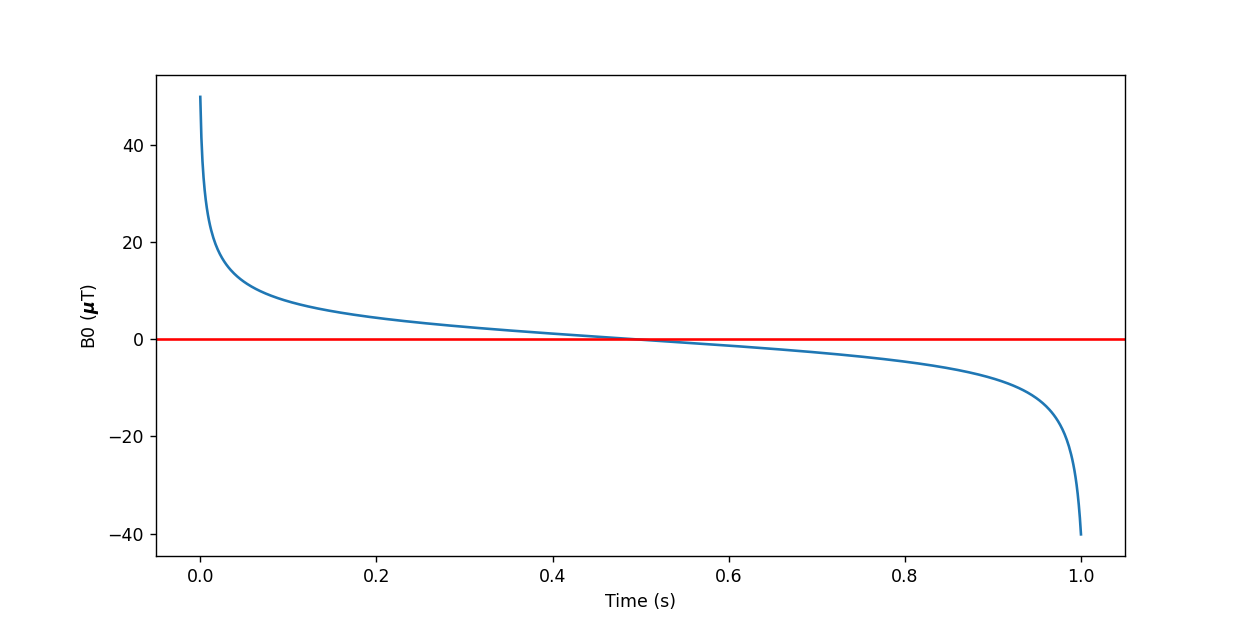

Text(0, 0.5, 'B0 ($\\mu$T)')

In [10]:
"""
Constant Adiabatic Inversion Profile for 1s Inverion Time
""";
Tinv_1s = np.linspace(0,1,Bopt.shape[-1])
plt.figure(2,(10,5))
plt.plot(Tinv_1s,Bopt*1.0e6)
plt.axhline(y = 0.0, color = 'r', linestyle = '-') 
plt.xlabel("Time (s)")
plt.ylabel(r"B0 ($\mu$T)")

## Initialize Density Matrix

In [11]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False

if Thermal_DensMatrix:
    LarmorF = System.LarmorFrequency(Gamma,Bmax,Offset)
    Hz = System.Zeeman(LarmorF,Sz)
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = Sz[0] # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))  

Trace of density metrix =  0j


In [12]:
# Intial Density Matrix
Matrix(rho_in)

Matrix([
[0.5,   0,    0,    0],
[  0, 0.5,    0,    0],
[  0,   0, -0.5,    0],
[  0,   0,    0, -0.5]])

In [13]:
# Initial Population

Population_H1_intial = System.OP_InnerProduct(Sz[0],rho_in)
Population_C13_intial = System.OP_InnerProduct(Sz[1],rho_in)
print("Polation diference two states of Proton = ",Population_H1_intial.real)
print("Polation diference two states of Carbon = ",Population_C13_intial.real)
#print("Ratio of Population_H1 and Population_C13 = ",(Population_H1/Population_C13).real) 

Polation diference two states of Proton =  1.0
Polation diference two states of Carbon =  0.0


## Population Transfer: 1H to 13C
### Population Vs Inversion Time

In [14]:
"""
I am going to vary inversion time and see how population transfer happens
""";
Max_InvTime = 0.02 # Maximum Inversion time
Inv_Points = 200 # Number of Inversion Time points
InvTime = np.linspace(0,Max_InvTime,Inv_Points,endpoint=True) # Inversion Time

rho = np.zeros((Inv_Points,System.Vdim,System.Vdim),dtype=complex)
rho_temp = np.zeros((System.Vdim,System.Vdim),dtype=complex)
start_time = time.time()
for j in range(Inv_Points):

    rho_temp = rho_in

    for i in range(Steps):
        LarmorF = System.LarmorFrequency(Gamma,Bopt[i],Offset)
        Hz = System.Zeeman(LarmorF,Sz)
        Htotal = Hz + Hj   
        prop = expm(-1j * Htotal * InvTime[j]/Steps)
        rho_temp = prop @ rho_temp @ prop.T.conj()
    rho[j] = rho_temp    
        
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))      

Total time = 28.302198886871338 seconds 


In [15]:
Pop_1H = Sz[0]
Pop_13C = Sz[1]
t, C13 = System.Expectation_H(rho,Pop_13C,dt,Inv_Points)
t, H1 = System.Expectation_H(rho,Pop_1H,dt,Inv_Points)

<IPython.core.display.Javascript object>


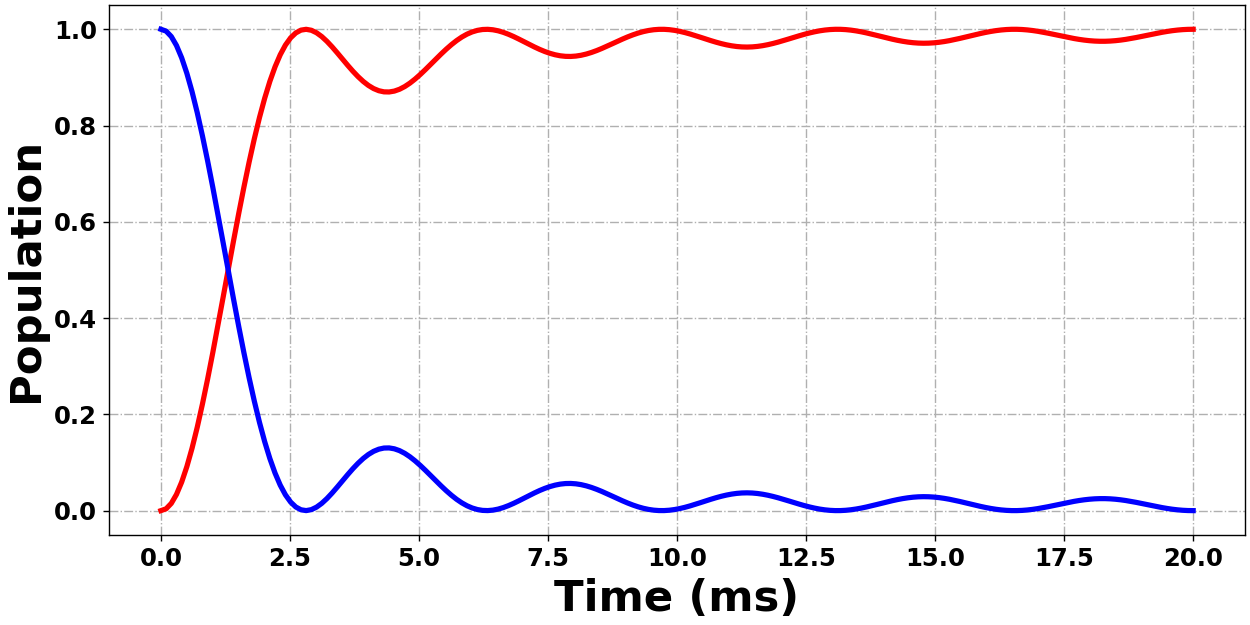

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [16]:
"""
Population
Red: 13C
Blue: 1H
""";
System.PlottingMulti(3,[InvTime*1.0e3,InvTime*1.0e3],[C13,H1],"Time (ms)","Population",["red","blue"])

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com